In [3]:
import copy
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from graph_based_slam import calc_3d_rotational_matrix, calc_jacobian, cal_observation_sigma, \
                             calc_input, observation, motion_model, Edge, pi_2_pi

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

# 1D Robot Movement
Our robot is on a line, with a control input $u_t$ of 1 meter forward. However, the motion is not ideal, and will vary. At teach timestep $t$ a sensor measurement is taken. There exists one landmark in our "map" at $x=3m$. At each timestep, the measurement we take is the range/distance to the landmark, which we recieve with noise.

To Solve for where we are in the "map" (on the line), we define two quantities, the system information matrix and the information vector, $H$ and $b$ respectively. We determine what these should be based on our control input and measurement at each timestep.

In [9]:
R = 0.2
Q = 0.2
N = 3
graphics_radius = 0.1

# Defining arrays of odometry (where we estimate we have moved to based on something like IMU), the measurement (obs) and the true position on the line.
odom = np.empty((N,1))
obs = np.empty((N,1))
x_true = np.empty((N,1))

landmark = 3


In [10]:
# Simulated readings of odometry and observations
x_true[0], odom[0], obs[0] = 0.0, 0.0, 2.9
x_true[1], odom[1], obs[1] = 1.0, 1.5, 2.0
x_true[2], odom[2], obs[2] = 2.0, 2.4, 1.0

hxDR = copy.deepcopy(odom)


# Plotting

x in green is our true position on the line, having moved exactly one each time. Blue is what we get from our odometry, and the red is our measurement of where we think the feature at 3m is, we get its position by adding our odometry with the measurement from our position.

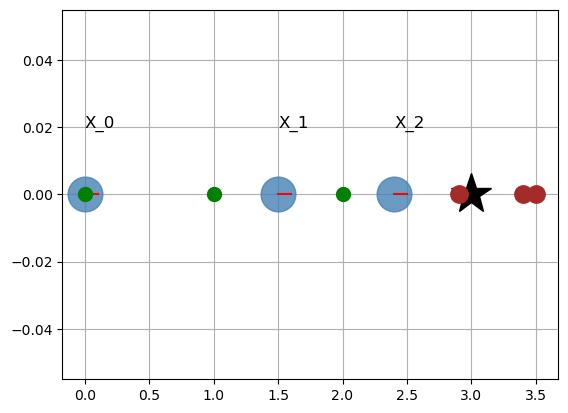

In [11]:
# Visualization
plt.plot(landmark,0, '*k', markersize=30)
for i in range(N):
    plt.plot(odom[i], 0, '.', markersize=50, alpha=0.8, color='steelblue')
    plt.plot([odom[i], odom[i] + graphics_radius],
             [0,0], 'r')
    plt.text(odom[i], 0.02, "X_{}".format(i), fontsize=12)
    plt.plot(obs[i]+odom[i],0,'.', markersize=25, color='brown')
    plt.plot(x_true[i],0,'.g', markersize=20)
plt.grid()
plt.show()

In [15]:
list(itertools.combinations(range(N),2))

[(0, 1), (0, 2), (1, 2)]

In [12]:
# Defined as a function to facilitate iteration
def get_H_b(odom, obs):
    """
    Create the information matrix and information vector. This implementation is
    based on the concept of virtual measurement i.e. the observations of the
    landmarks are converted into constraints (edges) between the nodes that
    have observed this landmark.
    """
    measure_constraints = {}
    omegas = {}
    zids = list(itertools.combinations(range(N),2)) # creates a list of N tuples of every combination of 0,1,2, where order doesn't matter
    H = np.zeros((N,N))
    b = np.zeros((N,1))
    for (t1, t2) in zids: # this is used such that we can have the correct indexes easily for are current and next odom and obs values
        x1 = odom[t1]
        x2 = odom[t2]
        z1 = obs[t1]
        z2 = obs[t2]

        # Adding virtual measurement constraint
        measure_constraints[(t1,t2)] = (x2-x1-z1+z2)
        omegas[(t1,t2)] = (1 / (2*Q))

        # populate system's information matrix and vector
        H[t1,t1] += omegas[(t1,t2)]
        H[t2,t2] += omegas[(t1,t2)]
        H[t2,t1] -= omegas[(t1,t2)]
        H[t1,t2] -= omegas[(t1,t2)]

        b[t1] += omegas[(t1,t2)] * measure_constraints[(t1,t2)]
        b[t2] -= omegas[(t1,t2)] * measure_constraints[(t1,t2)]

    return H, b

In [16]:
H, b = get_H_b(odom, obs)
print("The determinant of H: ", np.linalg.det(H))
H[0,0] += 1 # np.inf ?
print("The determinant of H after anchoring constraint: ", np.linalg.det(H))

The determinant of H:  0.0
The determinant of H after anchoring constraint:  18.750000000000007


In [17]:
for i in range(5):
    H, b = get_H_b(odom, obs)
    H[(0,0)] += 1

    # Recover the posterior over the path
    dx = np.linalg.inv(H) @ b
    odom += dx
    # repeat till convergence
print("Running graphSLAM ...")
print("Odometry values after optimzation: \n", odom)

Running graphSLAM ...
Odometry values after optimzation: 
 [[-0. ]
 [ 0.9]
 [ 1.9]]


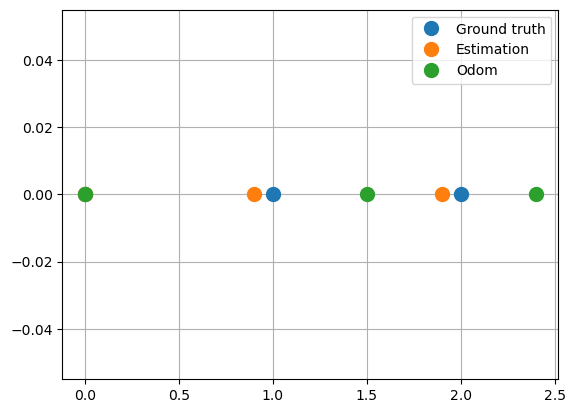

In [18]:
plt.figure()
plt.plot(x_true, np.zeros(x_true.shape), '.', markersize=20, label='Ground truth')
plt.plot(odom, np.zeros(x_true.shape), '.', markersize=20, label='Estimation')
plt.plot(hxDR, np.zeros(x_true.shape), '.', markersize=20, label='Odom')
plt.legend()
plt.grid()
plt.show()